<a href="https://colab.research.google.com/github/piyumaha12/Clootrack_assignment/blob/main/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [84]:
# !pip install googletrans
# !pip install pycld2

In [85]:
# !pip3 uninstall googletrans
# !pip3 install googletrans==3.1.0a0

In [198]:
import pandas as pd
import nltk
import re
import string
import os
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pycld2 as cld2


from sklearn.feature_extraction.text import CountVectorizer
# from spacy_langdetect import LanguageDetector
from googletrans import Translator
from wordcloud import WordCloud

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
PATH = '/content/drive/MyDrive/Clootrack/'

# Dataset import

In [89]:
data = pd.read_csv(PATH+'Data Analyst - Test Data - US.csv')

data.shape

(6448, 3)

In [90]:
def read_txt(path):
    with open(path, encoding='latin') as file:
        T = file.readlines()
    T = [x.strip() for x in T]
    T = T[30:]
    return T


In [91]:
positive_words = read_txt(PATH + 'positive-words.txt')
negative_words = read_txt(PATH + 'negative-words.txt')

In [92]:
afinn = pd.read_csv(PATH +'Afinn.csv', encoding= 'latin')

In [93]:
data.head()

,Review,date,Location
0,I was very impressed with the resort.\n Great ...,2019/08/20,Sebastian
1,The rooms were nice the outside needs work als...,2019/08/20,Los Angeles
2,Great location! I have stayed at this hotel on...,2019/08/20,Georgia
3,The hotel was adequate for my stay. The strips...,2019/08/20,NaN
4,"Great location, room was large and spacious. P...",2019/08/19,Palm Harbor


In [94]:
data.tail()

,Review,date,Location
6443,"·the staff were all so friendly. frank, the ch...",2019/07/12,United States of America
6444,·the internet barely worked or didn't work,2019/07/12,United States of America
6445,·the location was great.\n \n \n \n \n ·the be...,2019/07/10,United States of America
6446,·we were early for check in and the staff was ...,2019/07/10,United States of America
6447,"·staff, free coffee, location and activities.\...",2019/07/10,United States of America


In [95]:
data.Review[:10].values

array(['I was very impressed with the resort.\n Great staff at the main resort pool bar! We had a blast with them.\n Clean, professional staff, great location and very reasonable!\n  \n  Read more\n  Read less',
       'The rooms were nice the outside needs work also no free breakfast it would have been nice overall it was ok\n  \n  Read more\n  Read less',
       'Great location! I have stayed at this hotel on my last three trips to New York.\n  \n  Read more\n  Read less',
       'The hotel was adequate for my stay. The strips in the bathtub were useless as I fell while taking a shower. I asked the front desk staff several times to get a bath mat but they never did. Management was unresponsive to my request which was very poor; someone should have gone to a dollar store and gotten a bath mat. Breakfast was good but it would have been nice to have had yogurt and/or cottage cheese on the buffet.\n  \n  Read more\n  Read less',
       'Great location, room was large and spacious. Parkin

# Basic Exploration

In [96]:
data.describe()

,Review,date,Location
count,6393,6448,1711
unique,6384,403,1082
top,Amazing\n \n Read more\n Read less,Jun 2019,United States of America
freq,4,145,116


In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review    6393 non-null   object
 1   date      6448 non-null   object
 2   Location  1711 non-null   object
dtypes: object(3)
memory usage: 151.2+ KB


In [98]:
data.isnull().sum()

Review        55
date           0
Location    4737
dtype: int64

In [99]:
data = data.dropna(subset= ['Review'])

In [100]:
data.reset_index(inplace= True, drop = True)

In [101]:
data.isnull().sum()

Review         0
date           0
Location    4688
dtype: int64

In [102]:
data.Location.value_counts()[data.Location.value_counts() >= 5]

United States of America    116
New York                     34
San Jose                     19
California                   19
Florida                      16
Canada                       16
United Kingdom               14
New York, NY                 13
Toronto                      12
Miami                        12
Orlando                      12
NY                           12
Seattle                      12
San Diego                    11
Chicago                      11
Los Angeles                  10
Philadelphia                  9
NYC                           9
Boston                        9
Maryland                      8
New Jersey                    8
London                        8
Puerto Rico                   7
Washington, DC                7
Irvine                        6
Sacramento                    6
Singapore                     6
Michigan                      6
Tampa                         6
San Francisco                 6
Atlanta, GA                   5
Vancouve

## Looking for Non ASCII lines in reviews

In [103]:
# Finding Japanese comments or non-ascii

NON_ASCII = [a.isascii() for a in data.Review]
NON_ASCII = pd.Series(NON_ASCII)

In [104]:
data[NON_ASCII == False]

,Review,date,Location
8,My wife and I loved everything about it. It’s ...,2019/08/19,NaN
10,Very clean and friendly and I love the locatio...,2019/08/19,California
18,"It was great for what we needed, a place to sl...",2019/08/19,NaN
21,The room is tiny. The building is old and worn...,2019/08/18,NaN
23,基本的に問題なしでした。\n 清潔で防音も普通な方で、水回りも清潔でシャワーの水圧も問題なし...,2019/08/18,NaN
...,...,...,...
6388,"·the staff were all so friendly. frank, the ch...",2019/07/12,United States of America
6389,·the internet barely worked or didn't work,2019/07/12,United States of America
6390,·the location was great.\n \n \n \n \n ·the be...,2019/07/10,United States of America
6391,·we were early for check in and the staff was ...,2019/07/10,United States of America


In [105]:
NON_ASCII.value_counts()

True     4390
False    2003
dtype: int64

# Language Detection Before cleaning

In [106]:
T = data.Review[0]

In [107]:
T

'I was very impressed with the resort.\n Great staff at the main resort pool bar! We had a blast with them.\n Clean, professional staff, great location and very reasonable!\n  \n  Read more\n  Read less'

In [108]:
_,_,_, detected_language = cld2.detect(T, returnVectors = True )

In [109]:
detected_language[0][2]

'ENGLISH'

In [110]:
def language_detection(strn):
  _,_,_, detected_lang = cld2.detect(strn, returnVectors = True)
  if len(detected_lang) > 1:
    langs = []
    for j,i in enumerate(detected_lang):
      lang = i[2]
      if lang != 'Unknown':
        if len(langs) == 0:
          langs.append(lang)
        elif langs[-1] == lang:
          pass
        # print(langs[0])
  else:
    try:
      langs = detected_lang[0][2]
    except:
      langs = None
  return langs

def language_detection_list_2_str(X):
  if type(X) == str:
    return X
  elif type(X) == list and len(X) == 1:
    return X[0]
  elif type(X) == list and len(X)>1:
    return X


In [111]:
data['Languages']=data.Review.apply(language_detection)
data['Languages'] = data.Languages.apply(language_detection_list_2_str )

In [112]:
data['Languages'].isnull().sum()

0

In [113]:
data

,Review,date,Location,Languages
0,I was very impressed with the resort.\n Great ...,2019/08/20,Sebastian,ENGLISH
1,The rooms were nice the outside needs work als...,2019/08/20,Los Angeles,ENGLISH
2,Great location! I have stayed at this hotel on...,2019/08/20,Georgia,ENGLISH
3,The hotel was adequate for my stay. The strips...,2019/08/20,NaN,ENGLISH
4,"Great location, room was large and spacious. P...",2019/08/19,Palm Harbor,ENGLISH
...,...,...,...,...
6388,"·the staff were all so friendly. frank, the ch...",2019/07/12,United States of America,ENGLISH
6389,·the internet barely worked or didn't work,2019/07/12,United States of America,ENGLISH
6390,·the location was great.\n \n \n \n \n ·the be...,2019/07/10,United States of America,ENGLISH
6391,·we were early for check in and the staff was ...,2019/07/10,United States of America,ENGLISH


In [114]:
data.dtypes

Review       object
date         object
Location     object
Languages    object
dtype: object

In [115]:
data.Languages.value_counts()

ENGLISH       5767
Unknown        166
SPANISH        129
GERMAN          87
FRENCH          62
Japanese        40
ITALIAN         32
PORTUGUESE      30
DUTCH           21
DANISH          15
Korean          13
NORWEGIAN        9
SWEDISH          7
Chinese          5
FINNISH          4
ChineseT         2
RUSSIAN          2
POLISH           1
HEBREW           1
Name: Languages, dtype: int64

In [116]:
px.histogram(x = data.Languages)

In [117]:
data[data.Languages == 'Unknown']

,Review,date,Location,Languages
97,Simplemente espectacular en todo sentido y mom...,2019/08/09,NaN,Unknown
169,El restaurante d carne butcher and bank y la u...,2019/08/04,NaN,Unknown
280,Toda la estadía en este Hotel fue espectacular...,2019/07/24,NaN,Unknown
319,De ligging is middenin manhatten echt uitsteke...,2019/07/19,Rotterdam,Unknown
377,Instalaciones viejas. Habitaciones con alfombr...,2019/07/15,NaN,Unknown
...,...,...,...,...
6354,·الفندق اكثر من رائع,2019/07/20,Kuwait,Unknown
6358,·great location,2019/07/19,Canada,Unknown
6362,·location and very clean,2019/07/18,United States of America,Unknown
6368,·staff\n \n \n \n \n ·air condition was hot,2019/07/16,Puerto Rico,Unknown


# Data Cleaning

First of all we have to clean the dataset and then after we go for visualization and exploration.

We need to perform following tasks
1. Remove new lines
2. Remore "Read more" and "Read less"


In [118]:
def data_cleaning(strn):
    '''
    This function removes following things:
    - Remove emojis
    - Remove excessive blank spaces
    
    '''
    punct = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    strn = strn.encode('ascii', 'ignore').decode('ascii')
    strn = re.sub(r'http\S+\s*', '', strn)
    strn = re.sub(r'[#@]\w', '', strn)
    strn = strn.replace('\n', '')
    strn = strn.replace('Read more', '')
    strn = strn.replace('Read less', '')
    strn = re.sub(r' {2,}', ' ', strn)
    
    # strn = strn.replace('.', '') if strn[0][0] == '.' else strn
    strn = strn.strip()
    return strn


In [119]:
data['Review_regex']=data['Review'].apply(data_cleaning)

In [120]:
data['Review_cleaned'] = data['Review_regex'].apply(lambda x: re.sub('[%s]'%re.escape(string.punctuation), ' ', x))
data['Review_cleaned'] = data['Review_cleaned'].apply(lambda x: re.sub(r' {2,}', ' ', x))
data['Review_cleaned'] = data['Review_cleaned'].apply(lambda x: x.strip())

In [121]:
data.Review_regex.values[:10]

array(['I was very impressed with the resort. Great staff at the main resort pool bar! We had a blast with them. Clean, professional staff, great location and very reasonable!',
       'The rooms were nice the outside needs work also no free breakfast it would have been nice overall it was ok',
       'Great location! I have stayed at this hotel on my last three trips to New York.',
       'The hotel was adequate for my stay. The strips in the bathtub were useless as I fell while taking a shower. I asked the front desk staff several times to get a bath mat but they never did. Management was unresponsive to my request which was very poor; someone should have gone to a dollar store and gotten a bath mat. Breakfast was good but it would have been nice to have had yogurt and/or cottage cheese on the buffet.',
       'Great location, room was large and spacious. Parking was easy and we appreciated the friendly staff',
       'All the options for fun were great! Do wish there were a better p

In [122]:
data.Review_cleaned.values[:10]

array(['I was very impressed with the resort Great staff at the main resort pool bar We had a blast with them Clean professional staff great location and very reasonable',
       'The rooms were nice the outside needs work also no free breakfast it would have been nice overall it was ok',
       'Great location I have stayed at this hotel on my last three trips to New York',
       'The hotel was adequate for my stay The strips in the bathtub were useless as I fell while taking a shower I asked the front desk staff several times to get a bath mat but they never did Management was unresponsive to my request which was very poor someone should have gone to a dollar store and gotten a bath mat Breakfast was good but it would have been nice to have had yogurt and or cottage cheese on the buffet',
       'Great location room was large and spacious Parking was easy and we appreciated the friendly staff',
       'All the options for fun were great Do wish there were a better policy on the lazy

> Now the dataset is almost ready and clean
>
> Only one thing is to remove is Punctuation marks

In [123]:
data.isnull().sum()

Review               0
date                 0
Location          4688
Languages            0
Review_regex         0
Review_cleaned       0
dtype: int64

In [124]:
data[data.Review_cleaned == '']

,Review,date,Location,Languages,Review_regex,Review_cleaned
23,基本的に問題なしでした。\n 清潔で防音も普通な方で、水回りも清潔でシャワーの水圧も問題なし...,2019/08/18,NaN,Japanese,,
311,シャワーをすると光が必ず濡れます。\n \n Read more\n Read less,2019/07/20,NaN,Japanese,,
505,👍👍👍👍👍👍🌹👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍...,2019/07/05,NaN,Unknown,,
693,サンノゼ国際空港まで近くて送迎もあり便利ですね。\n \n Read more\n R...,2019/06/15,大阪,Japanese,,
723,バスタブ付きのお部屋で、きちんと熱いお湯も出て、ゆっくりお風呂に入れました。\n 町の中心部...,2019/06/10,東京,Japanese,,
1026,청소 상태가 깨끗하지 않고 객실은 작고 그냥 그런 호텔\n \n Read mor...,2019/05/12,NaN,Korean,,
1073,他のホテルと違ってリゾートフィーなどがかからず、明朗会計でした。\n ルームクリーニングも完...,2019/05/08,NaN,Japanese,,
1111,空港から近く、とても便利でした。館内も清潔で過ごしやすかったです。\n \n Read ...,2019/05/05,NaN,Japanese,,
1129,部屋のお湯が酷く濁っていた。それについてチェックアウト時にフロントに言ったが、謝罪の一つも無...,2019/05/04,NaN,Japanese,,
1258,無料の送迎シャトルバスにて、ディズニーエリアまで行けます。\n \n Read more...,2019/04/26,JAPAN,Japanese,,


As You can see all Non-English comments are blank to lets remove them

In [125]:
data = data[data.Review_cleaned != '']

In [126]:
data.reset_index(inplace= True, drop = True)

In [127]:
data

,Review,date,Location,Languages,Review_regex,Review_cleaned
0,I was very impressed with the resort.\n Great ...,2019/08/20,Sebastian,ENGLISH,I was very impressed with the resort. Great st...,I was very impressed with the resort Great sta...
1,The rooms were nice the outside needs work als...,2019/08/20,Los Angeles,ENGLISH,The rooms were nice the outside needs work als...,The rooms were nice the outside needs work als...
2,Great location! I have stayed at this hotel on...,2019/08/20,Georgia,ENGLISH,Great location! I have stayed at this hotel on...,Great location I have stayed at this hotel on ...
3,The hotel was adequate for my stay. The strips...,2019/08/20,NaN,ENGLISH,The hotel was adequate for my stay. The strips...,The hotel was adequate for my stay The strips ...
4,"Great location, room was large and spacious. P...",2019/08/19,Palm Harbor,ENGLISH,"Great location, room was large and spacious. P...",Great location room was large and spacious Par...
...,...,...,...,...,...,...
6336,"·the staff were all so friendly. frank, the ch...",2019/07/12,United States of America,ENGLISH,"the staff were all so friendly. frank, the che...",the staff were all so friendly frank the chef ...
6337,·the internet barely worked or didn't work,2019/07/12,United States of America,ENGLISH,the internet barely worked or didn't work,the internet barely worked or didn t work
6338,·the location was great.\n \n \n \n \n ·the be...,2019/07/10,United States of America,ENGLISH,the location was great. the bed was the most u...,the location was great the bed was the most un...
6339,·we were early for check in and the staff was ...,2019/07/10,United States of America,ENGLISH,we were early for check in and the staff was v...,we were early for check in and the staff was v...


In [128]:
data.Review_cleaned[:5].values

array(['I was very impressed with the resort Great staff at the main resort pool bar We had a blast with them Clean professional staff great location and very reasonable',
       'The rooms were nice the outside needs work also no free breakfast it would have been nice overall it was ok',
       'Great location I have stayed at this hotel on my last three trips to New York',
       'The hotel was adequate for my stay The strips in the bathtub were useless as I fell while taking a shower I asked the front desk staff several times to get a bath mat but they never did Management was unresponsive to my request which was very poor someone should have gone to a dollar store and gotten a bath mat Breakfast was good but it would have been nice to have had yogurt and or cottage cheese on the buffet',
       'Great location room was large and spacious Parking was easy and we appreciated the friendly staff'],
      dtype=object)

In [129]:
data.isnull().sum()

Review               0
date                 0
Location          4642
Languages            0
Review_regex         0
Review_cleaned       0
dtype: int64

# Language Detection After Cleaning

In [130]:
T = data.Review_cleaned[6306]

In [131]:
T

'great location'

In [132]:
_,_,_, detected_language = cld2.detect(T, returnVectors = True )

In [133]:
detected_language[0][2]

'Unknown'

In [134]:
def language_detection(strn):
  _,_,_, detected_lang = cld2.detect(strn, returnVectors = True)
  if len(detected_lang) > 1:
    langs = []
    for j,i in enumerate(detected_lang):
      lang = i[2]
      if lang != 'Unknown':
        if len(langs) == 0:
          langs.append(lang)
        elif langs[-1] == lang:
          pass
        # print(langs[0])
  else:
    try:
      langs = detected_lang[0][2]
    except:
      langs = None
  return langs

def language_detection_list_2_str(X):
  if type(X) == str:
    return X
  elif type(X) == list and len(X) == 1:
    return X[0]
  elif type(X) == list and len(X)>1:
    return X


In [135]:
data['Languages_2']=data.Review_cleaned.apply(language_detection)
data['Languages_2'] = data.Languages_2.apply(language_detection_list_2_str )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [136]:
data['Languages_2'].isnull().sum()

11

In [137]:
data

,Review,date,Location,Languages,Review_regex,Review_cleaned,Languages_2
0,I was very impressed with the resort.\n Great ...,2019/08/20,Sebastian,ENGLISH,I was very impressed with the resort. Great st...,I was very impressed with the resort Great sta...,ENGLISH
1,The rooms were nice the outside needs work als...,2019/08/20,Los Angeles,ENGLISH,The rooms were nice the outside needs work als...,The rooms were nice the outside needs work als...,ENGLISH
2,Great location! I have stayed at this hotel on...,2019/08/20,Georgia,ENGLISH,Great location! I have stayed at this hotel on...,Great location I have stayed at this hotel on ...,ENGLISH
3,The hotel was adequate for my stay. The strips...,2019/08/20,NaN,ENGLISH,The hotel was adequate for my stay. The strips...,The hotel was adequate for my stay The strips ...,ENGLISH
4,"Great location, room was large and spacious. P...",2019/08/19,Palm Harbor,ENGLISH,"Great location, room was large and spacious. P...",Great location room was large and spacious Par...,ENGLISH
...,...,...,...,...,...,...,...
6336,"·the staff were all so friendly. frank, the ch...",2019/07/12,United States of America,ENGLISH,"the staff were all so friendly. frank, the che...",the staff were all so friendly frank the chef ...,ENGLISH
6337,·the internet barely worked or didn't work,2019/07/12,United States of America,ENGLISH,the internet barely worked or didn't work,the internet barely worked or didn t work,ENGLISH
6338,·the location was great.\n \n \n \n \n ·the be...,2019/07/10,United States of America,ENGLISH,the location was great. the bed was the most u...,the location was great the bed was the most un...,ENGLISH
6339,·we were early for check in and the staff was ...,2019/07/10,United States of America,ENGLISH,we were early for check in and the staff was v...,we were early for check in and the staff was v...,ENGLISH


In [138]:
data.dtypes

Review            object
date              object
Location          object
Languages         object
Review_regex      object
Review_cleaned    object
Languages_2       object
dtype: object

In [139]:
data.Languages_2.value_counts()

ENGLISH       5672
Unknown        262
SPANISH        135
GERMAN          90
FRENCH          56
ITALIAN         33
PORTUGUESE      25
DUTCH           22
DANISH          14
NORWEGIAN        9
SWEDISH          7
FINNISH          4
POLISH           1
Name: Languages_2, dtype: int64

In [140]:
px.histogram(x = data.Languages_2)

In [141]:
data[data.Languages_2 == 'Unknown']

,Review,date,Location,Languages,Review_regex,Review_cleaned,Languages_2
28,En general excelente. Fantástica situación\n D...,2019/08/17,España,SPANISH,En general excelente. Fantstica situacin Dos p...,En general excelente Fantstica situacin Dos pe...,Unknown
85,Camera non disponibile e sporca. Lunghissime c...,2019/08/11,NaN,ENGLISH,Camera non disponibile e sporca. Lunghissime c...,Camera non disponibile e sporca Lunghissime co...,Unknown
96,Simplemente espectacular en todo sentido y mom...,2019/08/09,NaN,Unknown,Simplemente espectacular en todo sentido y mom...,Simplemente espectacular en todo sentido y mom...,Unknown
168,El restaurante d carne butcher and bank y la u...,2019/08/04,NaN,Unknown,El restaurante d carne butcher and bank y la u...,El restaurante d carne butcher and bank y la u...,Unknown
361,朝食付きで予約したのですが伝わっていなかったようでちょっと苦労しました。エクスペディアのIt...,2019/07/16,東京,Japanese,Itenary,Itenary,Unknown
...,...,...,...,...,...,...,...
6279,·no microwave,2019/07/26,United States of America,Unknown,no microwave,no microwave,Unknown
6306,·great location,2019/07/19,Canada,Unknown,great location,great location,Unknown
6310,·location and very clean,2019/07/18,United States of America,Unknown,location and very clean,location and very clean,Unknown
6316,·staff\n \n \n \n \n ·air condition was hot,2019/07/16,Puerto Rico,Unknown,staff air condition was hot,staff air condition was hot,Unknown


# Cleaning all NON-ENGLISH rows

In [142]:
data.Location.value_counts()[data.Location.value_counts() > 10].index

Index(['United States of America', 'New York', 'California', 'San Jose',
       'Florida', 'Canada', 'United Kingdom', 'New York, NY', 'Toronto',
       'Seattle', 'Miami', 'NY', 'Orlando', 'San Diego', 'Chicago'],
      dtype='object')

In [143]:
locations = ['United States of America', 'New York', 'California', 'San Jose',
       'Florida', 'Canada', 'United Kingdom', 'New York, NY', 'Toronto',
       'Seattle', 'Miami', 'NY', 'Orlando', 'San Diego', 'Chicago']

In [144]:
data_2 = data[(data.Languages_2 == 'ENGLISH') | (data.Location == 'United States of America')]

In [145]:
data_2.Languages_2.value_counts()

ENGLISH    5672
Unknown       9
Name: Languages_2, dtype: int64

In [146]:
data_2[data_2.Languages_2 == 'Unknown']

,Review,date,Location,Languages,Review_regex,Review_cleaned,Languages_2
6217,·everything,2019/08/09,United States of America,Unknown,everything,everything,Unknown
6228,·everything!\n \n \n \n \n ·nothing!,2019/08/06,United States of America,Unknown,everything! nothing!,everything nothing,Unknown
6239,·housekeeping staff\n \n \n \n \n ·restaurant com,2019/08/04,United States of America,Unknown,housekeeping staff restaurant com,housekeeping staff restaurant com,Unknown
6259,·the bed,2019/07/31,United States of America,Unknown,the bed,the bed,Unknown
6273,"·staff, cleanliness, price",2019/07/28,United States of America,Unknown,"staff, cleanliness, price",staff cleanliness price,Unknown
6276,·price for parking,2019/07/27,United States of America,Unknown,price for parking,price for parking,Unknown
6279,·no microwave,2019/07/26,United States of America,Unknown,no microwave,no microwave,Unknown
6310,·location and very clean,2019/07/18,United States of America,Unknown,location and very clean,location and very clean,Unknown
6318,·pool wasn't crowded,2019/07/16,United States of America,Unknown,pool wasn't crowded,pool wasn t crowded,Unknown


In [147]:
data_2.reset_index(inplace = True, drop = True)

# Lemmitization

In [149]:
nlp = spacy.load('en_core_web_sm')

data_2['lemmatized'] = data_2['Review_cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop == False)]))
data_2['lemmatized'] = [x.strip() for x in data_2['lemmatized']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Sentiment score using counts of positive and negative words

In [164]:
affinity_score = afinn.set_index('word')['value'].to_dict()

nlp = spacy.load('en_core_web_sm')
sentiment_lexicon = affinity_score

def calculate_sentiment(text: str = None):
    sent_score = 0
    if text:
        sentence = nlp(text)
        for word in sentence:
            sent_score += sentiment_lexicon.get(word.lemma_, 0)
    return sent_score
    
data_2['Sentiment'] = data_2['Review_cleaned'].apply(calculate_sentiment)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [165]:
px.histogram(data_frame= data_2, x = 'Sentiment')

In [166]:
data_2[data_2.Sentiment < -10 ]

,Review,date,Location,Languages,Review_regex,Review_cleaned,Languages_2,lemmatized,Sentiment
611,Do not valet your vehicle at this property!\n ...,2019/06/21,NaN,ENGLISH,Do not valet your vehicle at this property! I ...,Do not valet your vehicle at this property I m...,ENGLISH,valet vehicle property mistake allow valet mus...,-13
696,This was a terrible experience to me.\n First ...,2019/06/04,"Montreal, Canada",ENGLISH,This was a terrible experience to me. First of...,This was a terrible experience to me First of ...,ENGLISH,terrible experience book night stay hotel show...,-19
869,Carpets in hallways were gross & dirty. Same p...,2019/05/16,Visalia Ca,ENGLISH,Carpets in hallways were gross & dirty. Same p...,Carpets in hallways were gross dirty Same pict...,ENGLISH,carpet hallway gross dirty picture post hallwa...,-12
1697,Handicap room this sucks I hate the shower I h...,2019/03/24,Modesto ca,ENGLISH,Handicap room this sucks I hate the shower I h...,Handicap room this sucks I hate the shower I h...,ENGLISH,handicap room suck hate shower hate hate room,-12
1717,We were evacuated twice from the hotel. The fi...,2019/03/22,NaN,ENGLISH,We were evacuated twice from the hotel. The fi...,We were evacuated twice from the hotel The fir...,ENGLISH,evacuate twice hotel time Wednesday night 10 2...,-15
1725,"The condition of the rooms were very bad, dirt...",2019/03/22,NaN,ENGLISH,"The condition of the rooms were very bad, dirt...",The condition of the rooms were very bad dirty...,ENGLISH,condition room bad dirty smell bathroom floor ...,-15
1881,This place was a huge disappointment and we le...,2019/03/11,Walnut hill Illinois,ENGLISH,This place was a huge disappointment and we le...,This place was a huge disappointment and we le...,ENGLISH,place huge disappointment leave book different...,-12
2202,The hotel is old and gross. The rooms smelled ...,2019/2/11,"San Francisco, CA",ENGLISH,The hotel is old and gross. The rooms smelled ...,The hotel is old and gross The rooms smelled o...,ENGLISH,hotel old gross room smell warm pee pillow cas...,-13
2545,"Had bad experience. Room was dirty, staff was ...",2019/1/10,NaN,ENGLISH,"Had bad experience. Room was dirty, staff was ...",Had bad experience Room was dirty staff was un...,ENGLISH,bad experience room dirty staff unfriendly res...,-12
2686,This is a terrible place to stay. My room was ...,2019/01/02,"Pikeville, Ky",ENGLISH,This is a terrible place to stay. My room was ...,This is a terrible place to stay My room was h...,ENGLISH,terrible place stay room horrible hair lint al...,-15


In [167]:
data_2.Review[4241]

'The entrance & lobby seemed nice. \n After entrring our two rooms, we immediately saw the drips, dust, hair, damage on all our internal doors & bathroom. At 10:30pm a loud party with music blaring, started in the room connected to us. They were letting at least a dozen guys slip into the exit door for this party. We went to the desk to complain, we came back to being locked out of one of our rooms & no one doing anything to stop the party. Five trips to the front desk in our pj’s (walking around a big spill that no one would clean up) cound not get the door lock to work. It’s now 11:30pm. Party still raging and us huddled with the person who is locked out of their room. A security guy came to help. He was unable and we had to wait 20min for someone to drive to the hotel with their master key to re-set the lock. After I ask security why no one has stopped the party, he pounds on the door. The party raged on till past midnight and we were relocated. We never saw the party get stopped. T

In [168]:
data_2[data_2.Sentiment > 30 ]

,Review,date,Location,Languages,Review_regex,Review_cleaned,Languages_2,lemmatized,Sentiment
762,Beautiful hotel in a prime location with excel...,2019/05/26,NaN,ENGLISH,Beautiful hotel in a prime location with excel...,Beautiful hotel in a prime location with excel...,ENGLISH,beautiful hotel prime location excellent frien...,41
827,As an Australian family with two children (5&7...,2019/05/20,Western Australia,ENGLISH,As an Australian family with two children (5&7...,As an Australian family with two children 5 7y...,ENGLISH,australian family child 5 7yrs holiday visit D...,34
1543,WOW! This is a really nice hotel! I think the ...,2019/04/01,NaN,ENGLISH,WOW! This is a really nice hotel! I think the ...,WOW This is a really nice hotel I think the pe...,ENGLISH,wow nice hotel think perfect personal touch sh...,36
2340,My husband and I were very pleased with our st...,2019/01/28,"Chicago,Il",ENGLISH,My husband and I were very pleased with our st...,My husband and I were very pleased with our st...,ENGLISH,husband pleased stay New Yorker Jan 23 25 2019...,40
2690,Perfectly located for accessing all of the maj...,2019/01/01,NaN,ENGLISH,Perfectly located for accessing all of the maj...,Perfectly located for accessing all of the maj...,ENGLISH,perfectly locate access major attraction site ...,31
4096,My wife does not like elevators. So so we aske...,2018/09/15,Uk Midlands.,ENGLISH,My wife does not like elevators. So so we aske...,My wife does not like elevators So so we asked...,ENGLISH,wife like elevator ask impossible room low flo...,33


In [169]:
data_2.Review[762]

'Beautiful hotel in a prime location with excellent friendly and helpful staff.\n The hotel is much better than what it looks like on the pictures, it has a stunning setting with a lagoon that runs around the hotel, 2 pools and out door jacuzzi. The rooms have been modified and are excellent for what you need whilst staying in Orlando.\n The staff are amazing Anyka on reception especially who assisted no end and made it possible to upgrade to a premium room due to being there celebrating my birthday and being a member of the armed forces as it happened to be memorial weekend at the time, and this just enhanced the experience from start to finish. Sarah who works in both bars again is excellent, friendly and taking the time to speak to customers and ensuring they are looked after at all times whether it be in the hotel bar or the restaurant bar, a friendly face goes no end when people go out of their way to look after guests.\n The room service was excellent and done to a high standard 

# Encoding Sentiment Values

In [173]:
def encoding_sentiment_to_string(dataset, column_name):
    rows, colm = dataset.shape
    for i in range(rows):
        if dataset[column_name].iloc[i]>0:
            dataset[column_name].iloc[i] = 'Positive'
        elif dataset[column_name].iloc[i]<0:
            dataset[column_name].iloc[i] = 'Negative'
        else:
            dataset[column_name].iloc[i] = 'Neutral'

In [174]:
encoding_sentiment_to_string(data_2, 'Sentiment')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1965: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



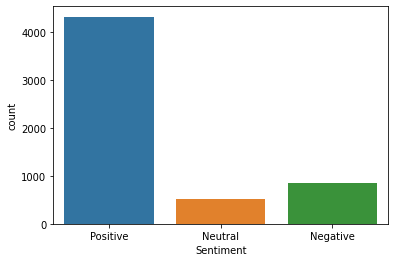

In [175]:
sns.countplot(x = data_2.Sentiment)

# Tokenization and WordClod

In [178]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [191]:
data_2.columns

Index(['Review', 'date', 'Location', 'Languages', 'Review_regex',
       'Review_cleaned', 'Languages_2', 'lemmatized', 'Sentiment'],
      dtype='object')

In [192]:
list_of_reviews = data_2.lemmatized.to_list()
string_of_reviews = ' '.join(list_of_reviews)

In [193]:
tokens = nltk.word_tokenize(string_of_reviews)

In [194]:
len(tokens)

112653

In [195]:
freq_dist = nltk.FreqDist(tokens)

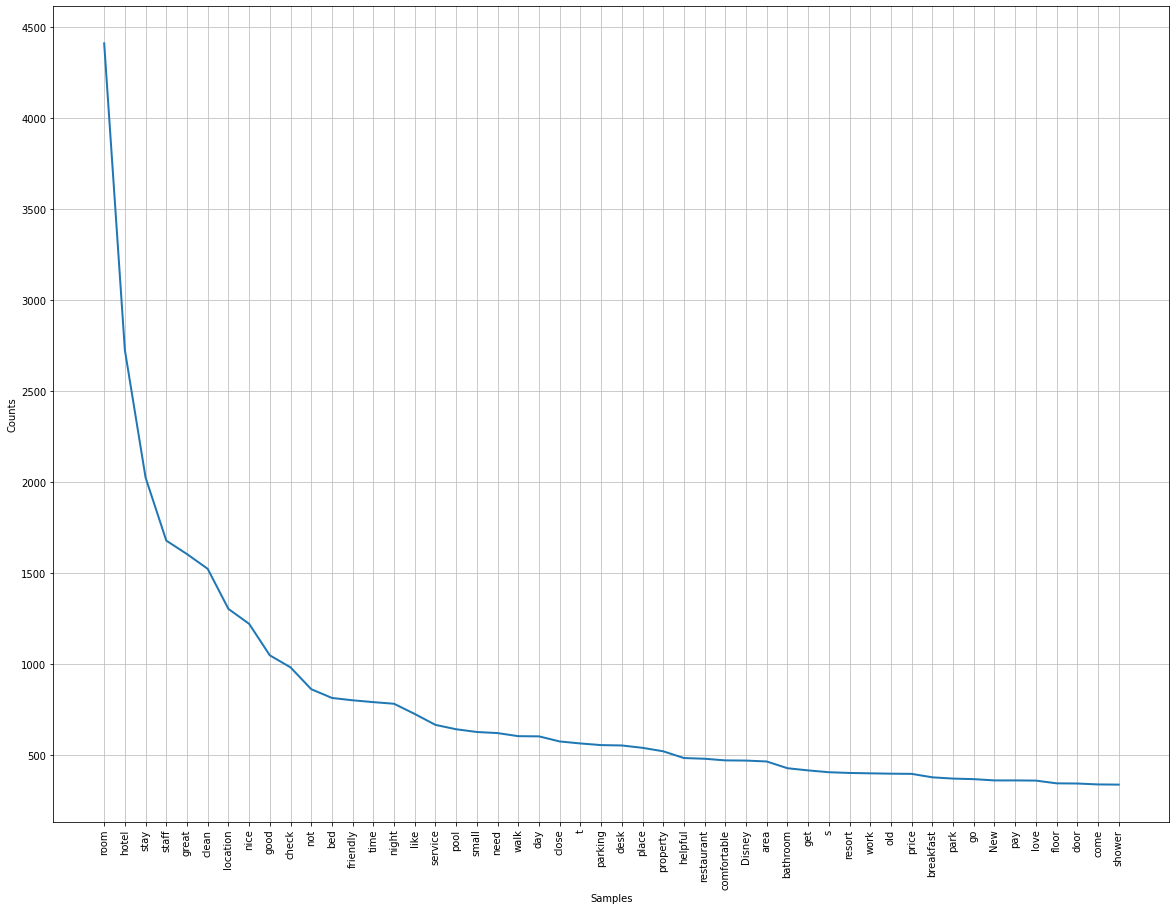

In [196]:
plt.figure(figsize = (20,15))
freq_dist.plot(50)

In [200]:
def plot_cloud(wordcloud):
    plt.figure(figsize = (40,30))
    plt.imshow(wordcloud)
    plt.axis('off')

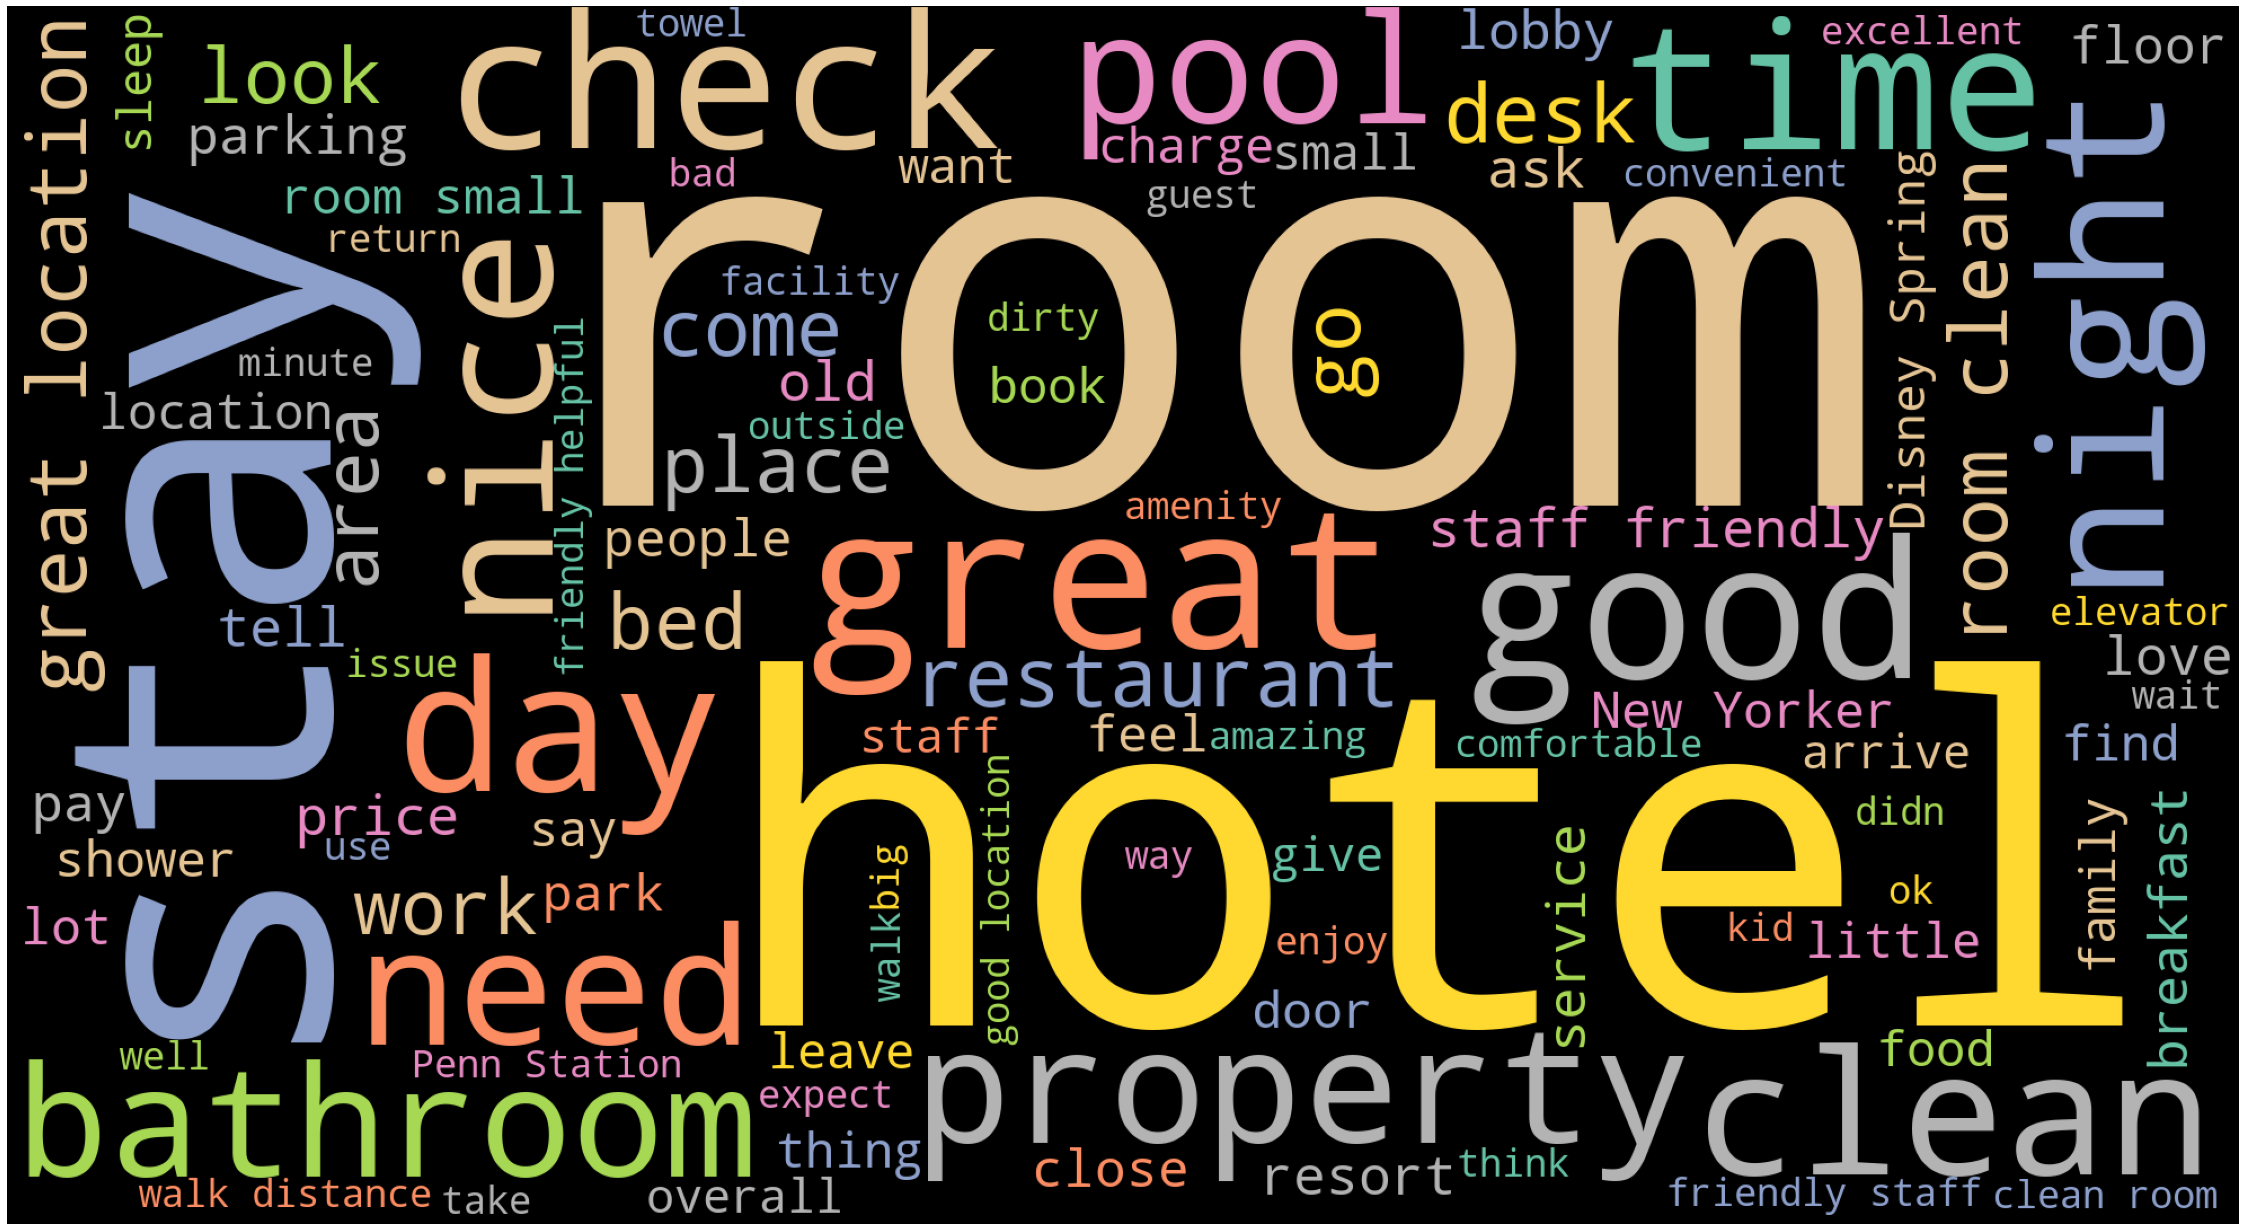

In [201]:
wordcloud = WordCloud(width = 1980, height = 1080, 
                      background_color='black', max_words=100,
                      colormap='Set2').generate(string_of_reviews)
# Plot
plot_cloud(wordcloud)

In [204]:
def wordcloud_function(data, title_string, big_image = True):
    wordcloud = WordCloud(width = 3000, 
    height = 2000, 
    background_color='black', 
    max_words=150,colormap='Set2',
    ).generate(str(data))
# Plot
    
    if big_image == True:
        plot_cloud(wordcloud)
    else:
        plt.figure(figsize= (10,10))
        plt.title(title_string)
        plt.imshow(wordcloud)

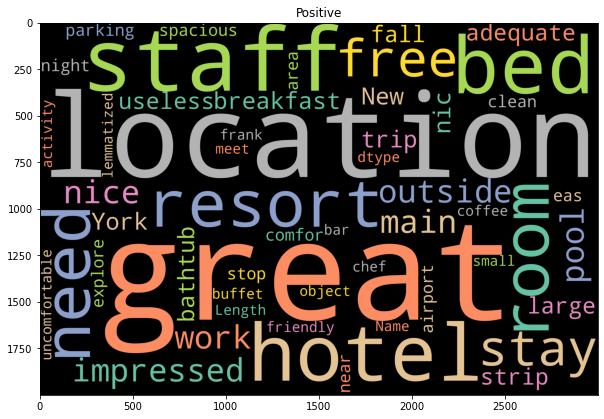

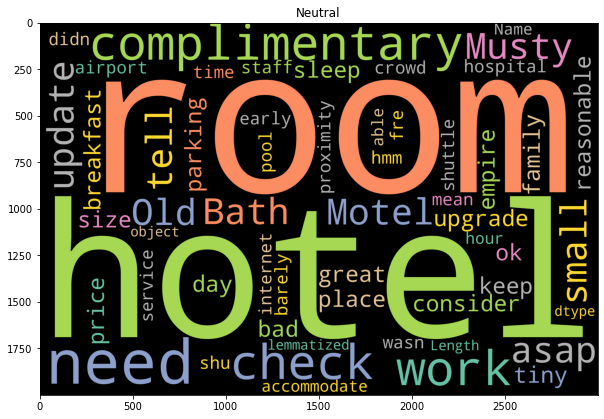

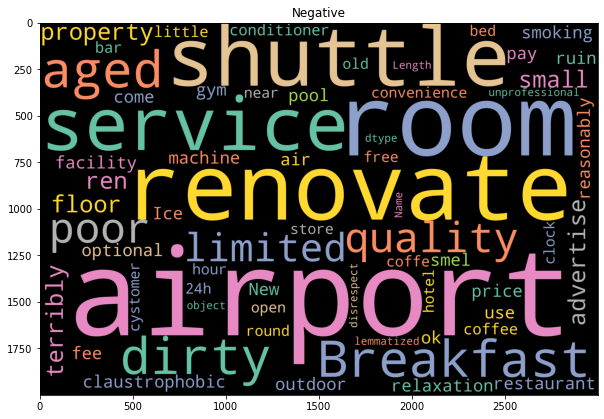

In [205]:
positive_review_dataframe = data_2[data_2['Sentiment'] == 'Positive']['lemmatized']
neutral_review_datafram = data_2[data_2['Sentiment']=='Neutral']['lemmatized']
negative_review_dataframe = data_2[data_2['Sentiment'] == 'Negative']['lemmatized']

wordcloud_function(positive_review_dataframe, 'Positive', big_image=False)
wordcloud_function(neutral_review_datafram, 'Neutral', big_image=False)
wordcloud_function(negative_review_dataframe, 'Negative', big_image= False)

# Analysis Based on N-gram

## Functions

In [208]:
def frequency_dict_functn(transformet_data, count_vector_model):
    x = transformet_data.toarray().sum(axis = 0)
    y = count_vector_model.get_feature_names_out()
    frequency_dict = dict(zip(y,x))
    return frequency_dict


def n_gram_countplot(dataframe, count_limit, title_str, range_tuple = (1,1), figsize= (20,15), rotation_amt = 40):
    cv = CountVectorizer(ngram_range= range_tuple)
    data = cv.fit_transform(dataframe)
    dict_count = frequency_dict_functn(data, cv)
    frequency_df = pd.DataFrame(dict_count.values(), index= dict_count.keys(), columns= ['counts'])
    counts_ = frequency_df[frequency_df['counts'] >count_limit]
    plt.figure(figsize= figsize)
    sns.set_style(style = 'dark')
    sns.barplot(x = counts_.index, y = counts_['counts'], palette= sns.cubehelix_palette())
    plt.title(title_str, fontsize = 16)
    plt.xticks(rotation = (rotation_amt), fontsize = 14)
    plt.show()



## One-Gram Word combination

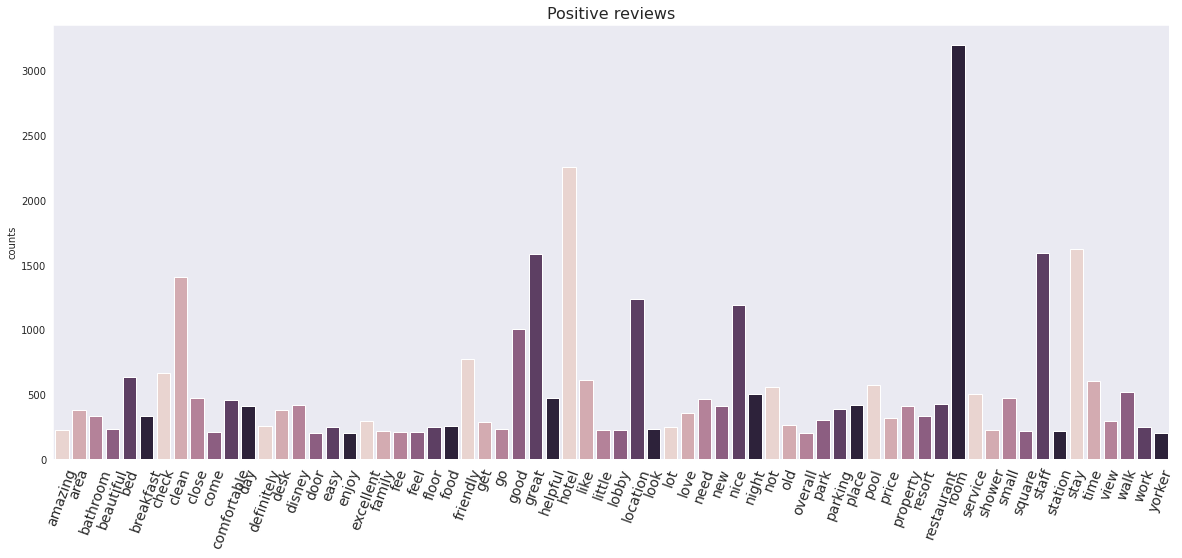

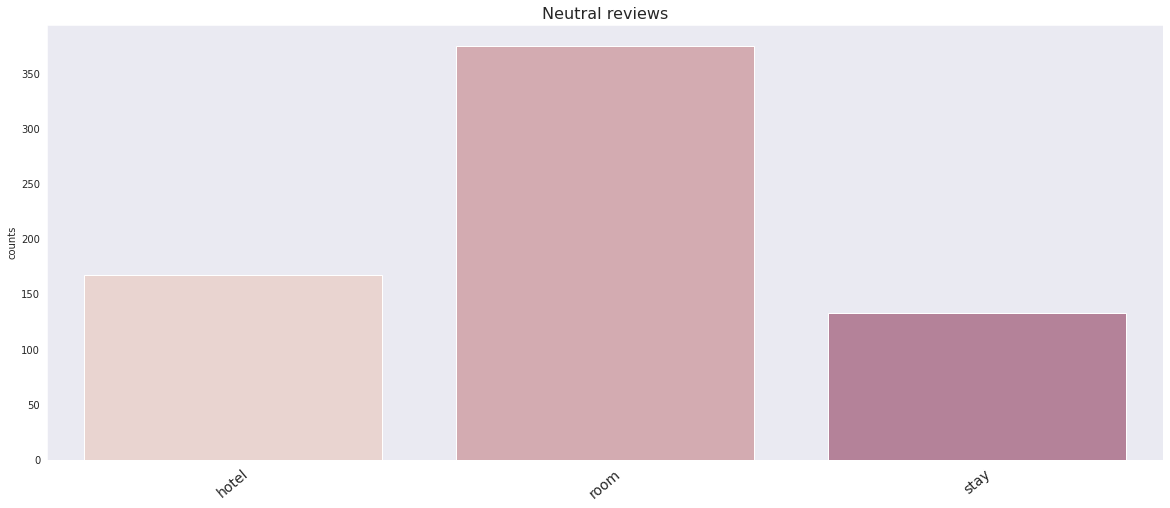

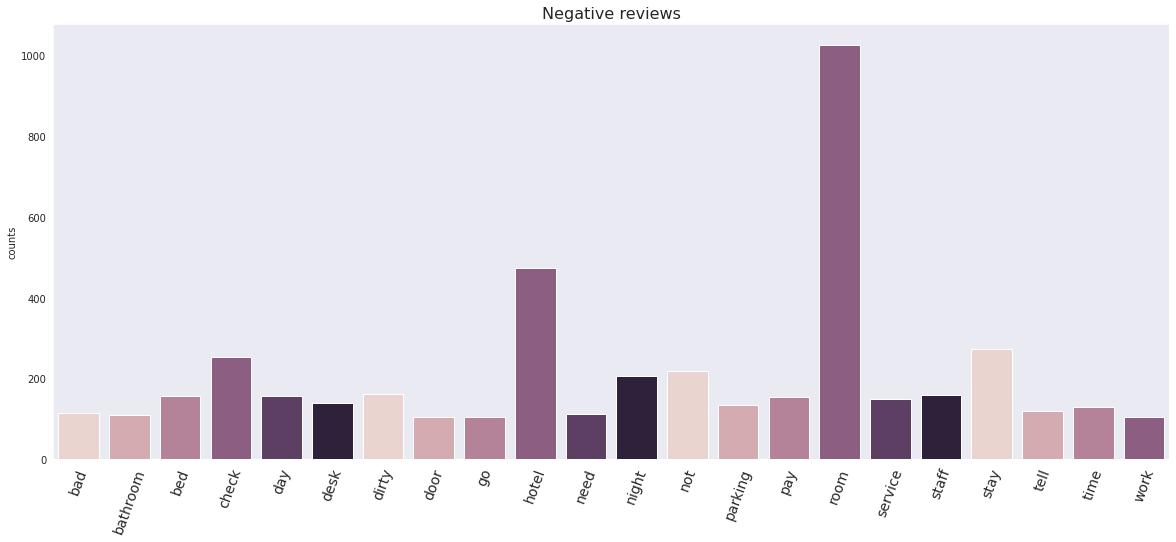

In [210]:
n_gram_countplot(positive_review_dataframe, 200, 'Positive reviews', range_tuple= (1,1), figsize= (20,8), 
                    rotation_amt= 70)
n_gram_countplot(neutral_review_datafram, 100, 'Neutral reviews', range_tuple= (1,1), figsize= (20,8))
n_gram_countplot(negative_review_dataframe, 100, 'Negative reviews',
         range_tuple= (1,1), figsize= (20,8), rotation_amt= 70)

Bi-Gram Analysis

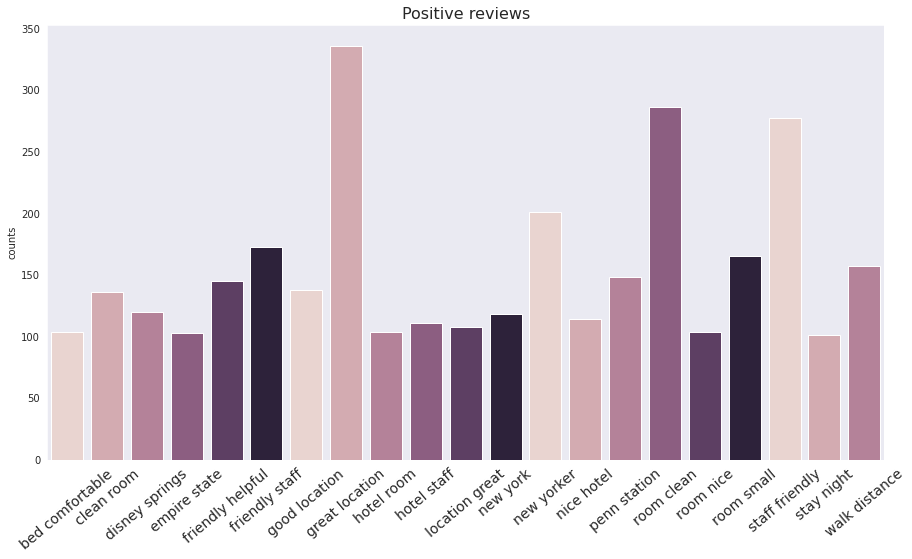

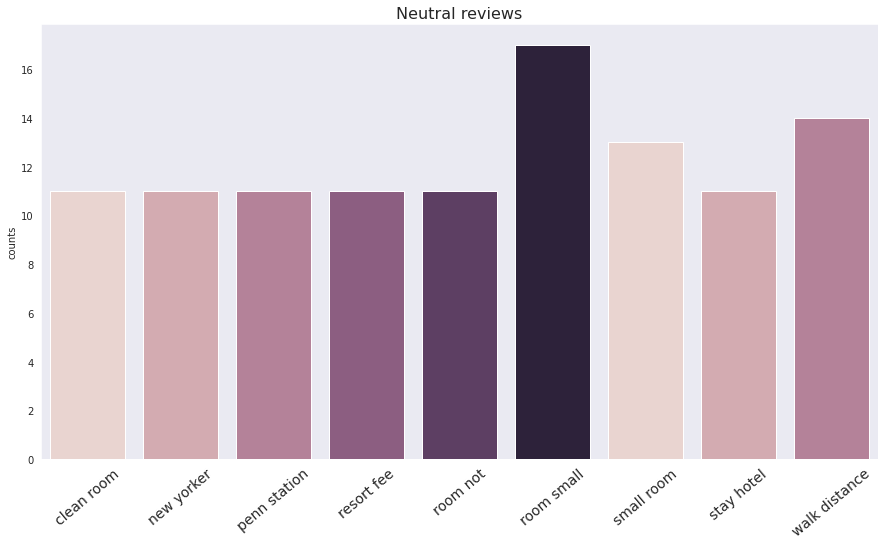

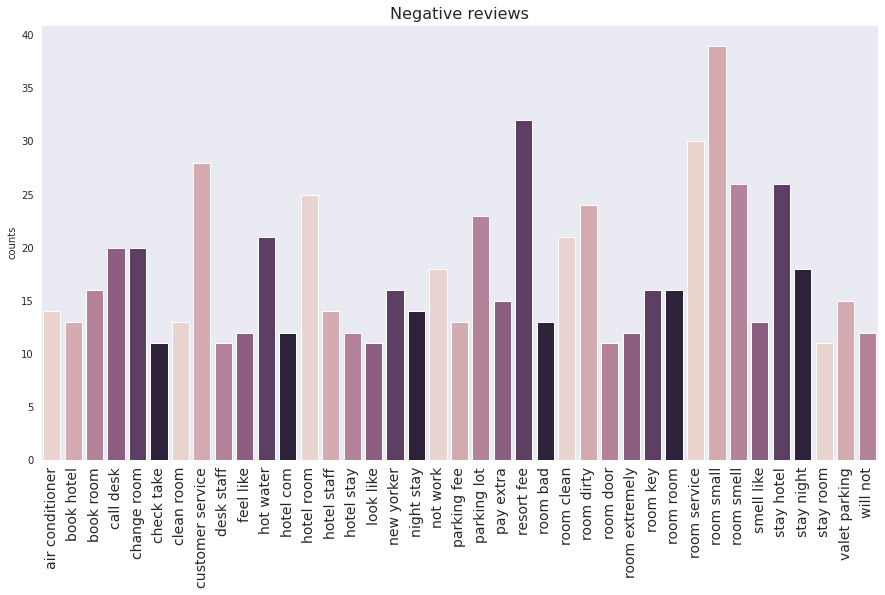

In [212]:
n_gram_countplot(positive_review_dataframe, 100, 'Positive reviews', range_tuple= (2,2), figsize= (15,8))
n_gram_countplot(neutral_review_datafram, 10, 'Neutral reviews', range_tuple= (2,2), figsize= (15,8))
n_gram_countplot(negative_review_dataframe, 10, 'Negative reviews',
         range_tuple= (2,2), figsize= (15,8), rotation_amt= 90)


## Tri-gram Analysis

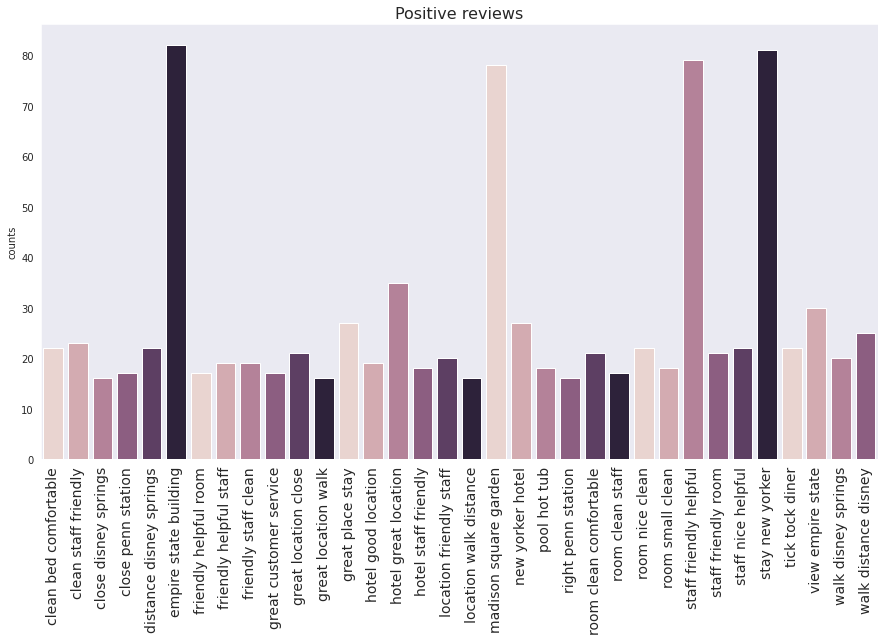

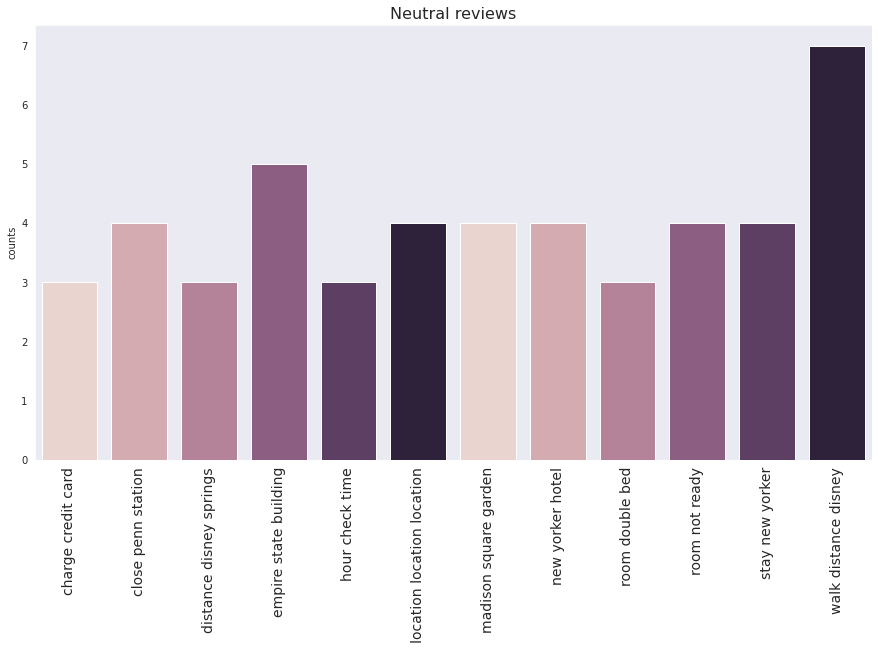

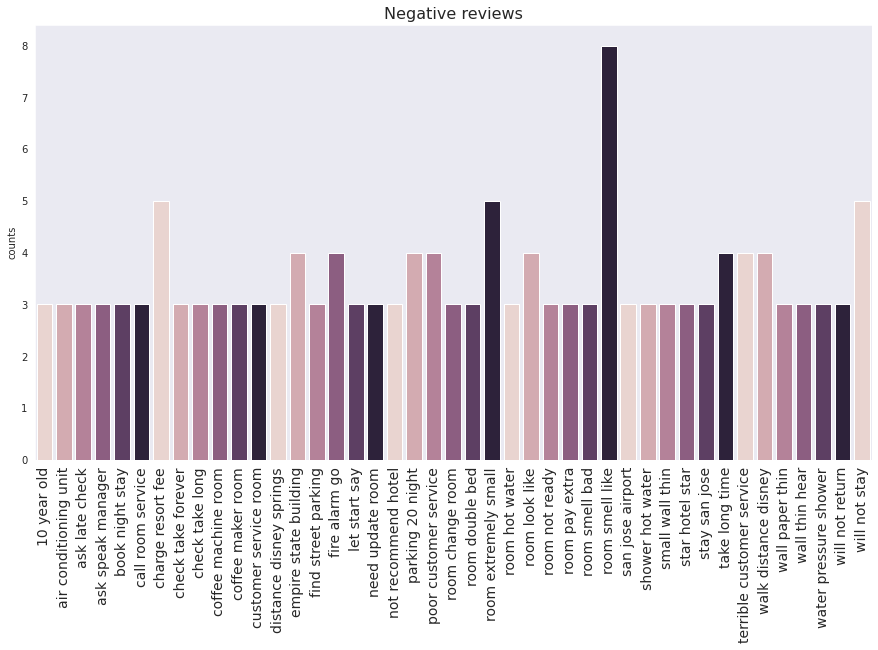

In [217]:
n_gram_countplot(positive_review_dataframe, 15, 'Positive reviews', range_tuple= (3,3),
                     figsize= (15,8), rotation_amt=90)
n_gram_countplot(neutral_review_datafram, 2, 'Neutral reviews', 
                 range_tuple= (3,3), figsize= (15,8), rotation_amt=90)
n_gram_countplot(negative_review_dataframe, 2, 'Negative reviews',
         range_tuple= (3,3), figsize= (15,8), rotation_amt=90)


4 - Gram Analysis

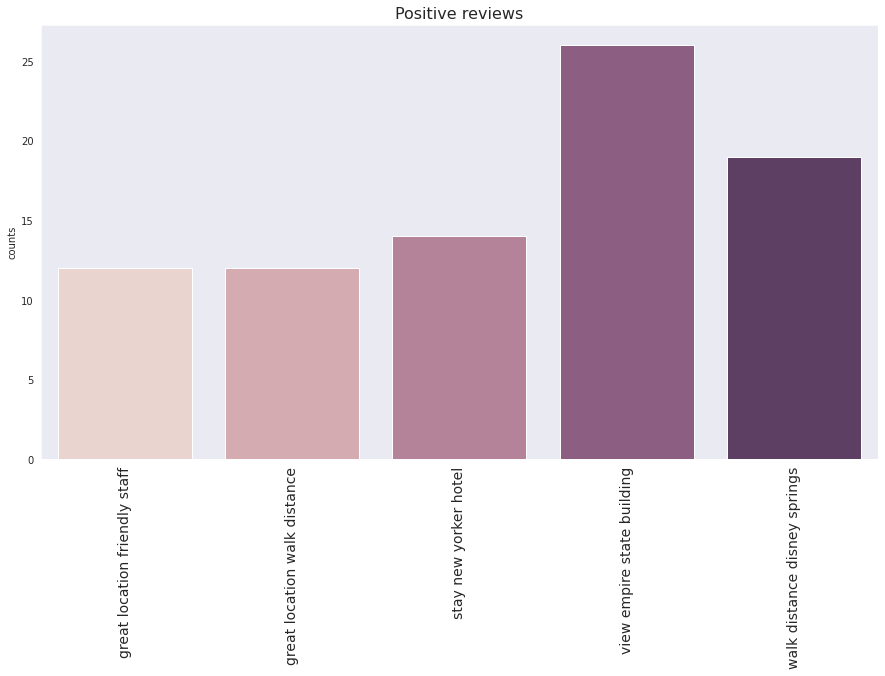

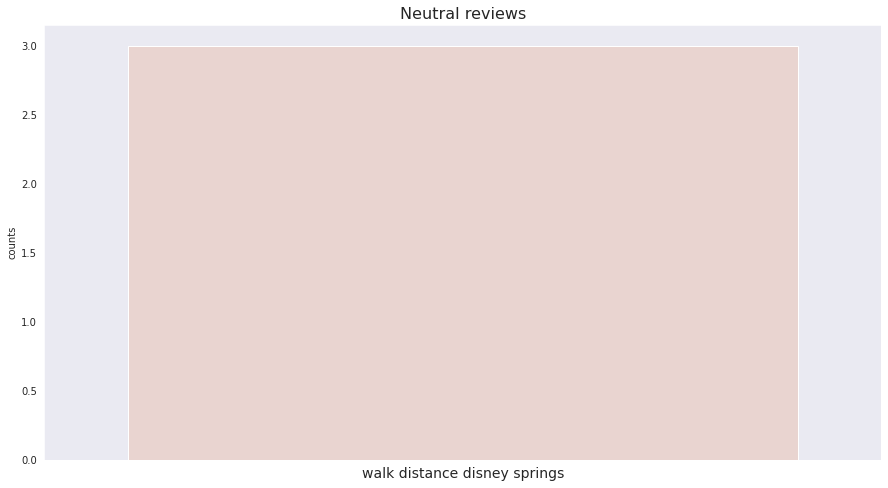

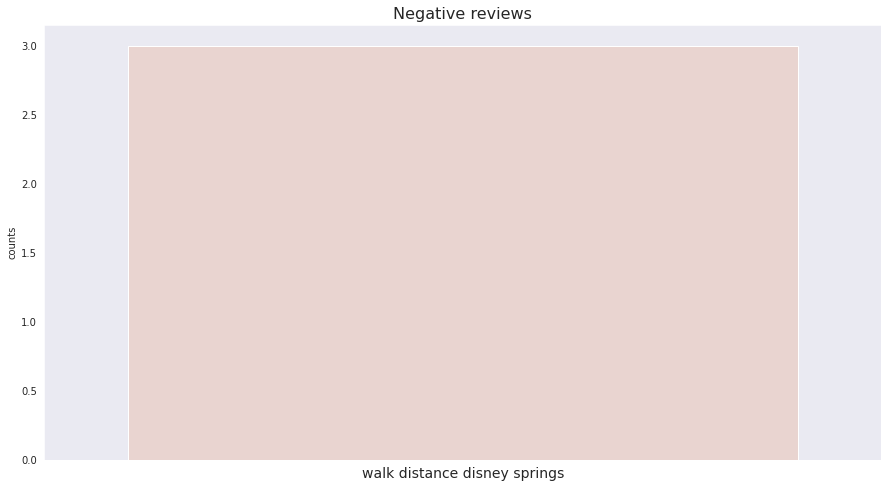

In [219]:
n_gram_countplot(positive_review_dataframe, 10, 'Positive reviews', range_tuple= (4,4),
                     figsize= (15,8), rotation_amt=90)
n_gram_countplot(neutral_review_datafram, 2, 'Neutral reviews', range_tuple= (4,4), figsize= (15,8), rotation_amt=0)
n_gram_countplot(negative_review_dataframe, 2, 'Negative reviews',
         range_tuple= (4,4), figsize= (15,8), rotation_amt=0)
